## Installation and imports

In [1]:
#@title Install required packages.
try:
    from google.colab import files  # checks if you are on google colab
    !rm -rf CogModelingRNNsTutorial
    !git clone https://github.com/whyhardt/CogModelingRNN.git
    %pip install -e CogModelingRNN/CogModelingRNNsTutorial
    !cp CogModelingRNN/CogModelingRNNsTutorial/*py CogModelingRNN
    %pip install pysindy
    _ON_COLAB = True
except:
    print('Not on Google Colab. Assuming you already installed the required packages.')

Not on Google Colab. Assuming you already installed the required packages.


In [2]:
#@title Import libraries
import sys
import os
import warnings
from typing import Callable, Tuple, Iterable, Union

import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr
import numpy as np
import pandas as pd
import scipy.stats as st
import pickle

# deepmind related libraries
import haiku as hk
import jax
import jax.numpy as jnp
import optax

import pysindy as ps

warnings.filterwarnings("ignore")

# RL libraries
sys.path.append('resources')  # add source directoy to path
from resources import bandits, disrnn, hybrnn, hybrnn_forget, plotting, rat_data, rnn_utils

In [3]:
from resources.models import AgentSindy


def get_q(experiment: bandits.BanditSession, agent: Union[bandits.AgentQ, bandits.AgentNetwork, AgentSindy]):
  """Compute Q-Values of a specific agent for a specific experiment.

  Args:
      experiment (bandits.BanditSession): _description_
      agent (_type_): _description_

  Returns:
      _type_: _description_
  """
  
  choices = np.expand_dims(experiment.choices, 1)
  rewards = np.expand_dims(experiment.rewards, 1)
  qs = np.zeros((experiment.choices.shape[0], agent._n_actions))
  choice_probs = np.zeros((experiment.choices.shape[0], agent._n_actions))
  
  agent.new_sess()
  
  for trial in range(experiment.choices.shape[0]):
    qs[trial] = agent.q
    choice_probs[trial] = agent.get_choice_probs()
    agent.update(int(choices[trial]), float(rewards[trial]))
    
  return qs, choice_probs


def parse_equation_for_sympy(eq):
    # replace all blank spaces with '*' where necessary
    # only between number and letter in exactly this order
    blanks = [i for i, ltr in enumerate(eq) if ltr == ' ']
    for blank in blanks:
        if (eq[blank+1].isalpha() or eq[blank-1].isdigit()) and (eq[blank+1].isalpha() or eq[blank+1].isdigit()):
            eq = eq[:blank] + '*' + eq[blank+1:]
    
    # replace all '^' with '**'
    eq = eq.replace('^', '**')
    
    # remove all [k]
    eq = eq.replace('[k]', '')

    return eq

# RNN Reinforcement Learning

## Set up agent and generate training data

In [4]:
# agent parameters
agent_kw = 'basic'  #@param ['basic', 'quad_q'] 
gen_alpha = .25 #@param
gen_beta = 5 #@param
forgetting_rate = 0.1 #@param
perseveration_bias = 0.  #@param
# environment parameters
non_binary_reward = False #@param
n_actions = 2 #@param
sigma = .1  #@param

# experiement parameters
n_trials_per_session = 200  #@param
n_sessions = 220  #@param

In [5]:
from main import main

rnnsindyestimator, dataset, agent = main(forgetting_rate=0.1, perseveration_bias=0.0, n_sessions=220,
                                         n_trials_per_session=200,
                                         sigma=0.1,
                                         non_binary_reward=False,
                                         params_path='rnn_params.pkl', agent_kw='basic', train=True, load=False,
                                         loss_function='categorical',
                                         convergence_thresh=1e-5, n_steps_max=10000,
                                         habit_weight=0.0, n_actions=2, get_choices=True, threshold=0.01,
                                         ensemble=False, library_ensemble=False,
                                         alpha=0.1, beta=3, dt=1.0, normalize=False, verbose=False)
hybrnn_agent = rnnsindyestimator.rnn_trainer.visible_agent
rnnsindyagent = rnnsindyestimator.sindy_trainer.sindyagent
rnnsindy = rnnsindyestimator.sindy_trainer.sindy
experiment_list_hybrnn = rnnsindyestimator.experiment_list_hybrnn
update_rule_rnnsindy = rnnsindyagent.get_update_rule()

Training the hybrid RNN...
Step 500 of 500; Loss: 0.6677576; Time: 6.6s)
Model not yet converged - Running more steps of gradient descent. Time elapsed = 1e-05s.
Step 500 of 500; Loss: 0.6675814; Time: 6.0s)
Model not yet converged (convergence_value = 0.0002638552) - Running more steps of gradient descent. Time elapsed = 2e-05s.
Step 500 of 500; Loss: 0.6675794; Time: 6.4s)
Model Converged! Time elapsed = 1e-05s.
Parameters saved.
Shape of Q-Values is: (440, 200, 1)
Shape of control parameters is: (440, 200, 2)
Feature names are: ['q', 'c', 'r']
(q)[k+1] = 0.017 1 + 0.569 q[k] + -558941567875.960 c[k] + -0.099 q[k]^2 + -5177628664.776 q[k] c[k] + 5925644515.913 q[k] r[k] + 285582017761.361 c[k]^2 + -9579962234.366 c[k] r[k] + 0.022 q[k]^3 + 0.047 q[k]^2 c[k] + 5177628665.111 q[k] c[k]^2 + -0.029 q[k] c[k] r[k] + -5925644515.857 q[k] r[k]^2 + 273359550114.427 c[k]^3 + 4789981117.333 c[k]^2 r[k] + 4789981117.333 c[k] r[k]^2
Sparsity index: 0.5


## Train SINDy on actual data and replace agent's update rule with SINDy update rule

The target equation for SINDy with forgetting is:

$$Q_\text{k+1}=(1-f)Q_\text{k} + f Q_0 - \alpha (1-f) c Q_\text{k} - \alpha f Q_0 c + \alpha c r$$

For the values $f=0.1$, $\alpha=0.25$, $Q_0=0.5$ this gives the constants
$$Q_\text{k+1}=0.9 Q_\text{k} + 0.05 - 0.225 c Q_\text{k} -  0.0125 c + 0.25 c r$$

In [6]:
get_choices = True
poly_order = 3
threshold = 0.01
dt = 1

custom_lib_functions = [
    # sub-library which is always included    
    lambda q,c,r: q,
    lambda q,c,r: r,
    lambda q,c,r: np.power(q, 2),
    lambda q,c,r: q*r,
    lambda q,c,r: np.power(r, 2),
    # sub-library if the possible action was chosen
    lambda q,c,r: c,
    lambda q,c,r: c*q,
    lambda q,c,r: c*r,
    lambda q,c,r: c*np.power(q, 2),
    lambda q,c,r: c*q*r,
    lambda q,c,r: c*np.power(r, 2),
]

custom_lib_names = [
    # part library which is always included
    lambda q,c,r: f'{q}',
    lambda q,c,r: f'{r}',
    lambda q,c,r: f'{q}^2',
    lambda q,c,r: f'{q}*{r}',
    lambda q,c,r: f'{r}^2',
    # part library if the possible action was chosen
    lambda q,c,r: f'{c}',
    lambda q,c,r: f'{c}*{q}',
    lambda q,c,r: f'{c}*{r}',
    lambda q,c,r: f'{c}*{q}^2',
    lambda q,c,r: f'{c}*{q}*{r}',
    lambda q,c,r: f'{c}*{r}^2',
]

# solution library for f=0.5, alpha=0.25, Q_init=0.5
# solution_lib = ps.CustomLibrary(
#     library_functions=[lambda q,c,r: 0.5*q + 0.25 - 0.125*c*q - 0.0675*c + 0.25*c*r],
#     function_names=[lambda q,c,r: f'0.5*q + 0.25 - 0.125*c*q - 0.0675*c + 0.25*c*r'],
#     include_bias=False,
#     library_ensemble=False,
# )

For the values $f=0.5$, $\alpha=0.25$ and $Q_0=0.5$ the discovered model should be equal to
$$Q_\text{k+1}=0.9 Q_\text{k} + 0.05 - 0.225 c Q_\text{k} -  0.0125 c + 0.25 c r$$

In [7]:
# Fit SINDy on actual dataset
ensemble = False
library_ensemble = False

library_datasindy = ps.PolynomialLibrary(3)

experiment_list_datasindy = None

x_train, control, feature_names = rnnsindyestimator.sindy_trainer.make_sindy_data(dataset.experiment_list_train, agent,
                                                                                  get_choices=get_choices)

datasindy = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, verbose=True, alpha=0.1),
    feature_library=library_datasindy,
    discrete_time=True,
    feature_names=feature_names,
)
datasindy.fit(x_train, t=dt, u=control, ensemble=ensemble, library_ensemble=library_ensemble, multiple_trajectories=True)
datasindy.print()

# set new sindy update rule and synthesize new dataset
if not get_choices:
    update_rule_datasindy = lambda q, choice, reward: datasindy.simulate(q[choice], t=2, u=np.array(reward).reshape(1, 1))[-1]
else:
    update_rule_datasindy = lambda q, choice, reward: datasindy.simulate(q, t=2, u=np.array([choice, reward]).reshape(1, 2))[-1]

datasindyagent = AgentSindy(alpha=0, beta=gen_beta, n_actions=n_actions)
datasindyagent.set_update_rule(update_rule_datasindy)

Shape of Q-Values is: (440, 200, 1)
Shape of control parameters is: (440, 200, 2)
Feature names are: ['q', 'c', 'r']
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 3.2640e+00 ... 7.0157e-02 ...          9 ... 3.3342e+00
         1 ... 2.6612e-02 ... 7.0923e-02 ...          9 ... 9.7534e-02
(q)[k+1] = 0.048 1 + 0.908 q[k] + -0.013 q[k]^2 + -239655.808 q[k] c[k] + -721734909.427 c[k] r[k] + 0.012 q[k]^3 + 239655.709 q[k] c[k]^2 + 360867454.764 c[k]^2 r[k] + 360867454.764 c[k] r[k]^2


## Fit a hybrid RNN and train SINDy on RNN dynamics

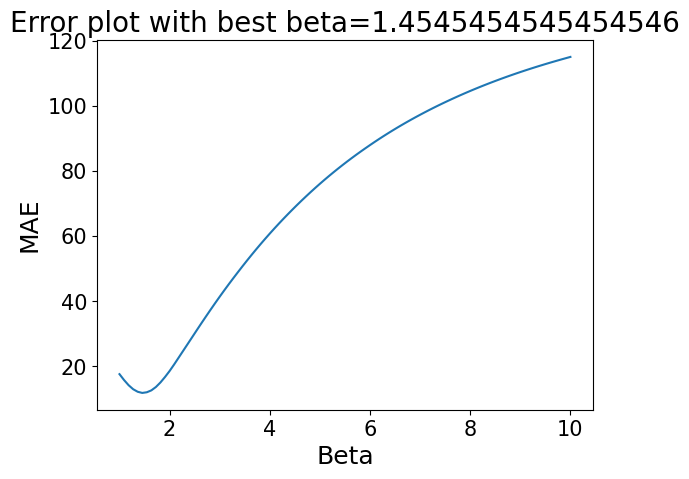

Setting up SINDy agent with beta=1.4545454545454546...


In [9]:
# POST-PROCESSING

# fit beta parameter of softmax by fitting on choice probability of the RNN by simple grid search

# number of observed points
n_points = 100

# epochs
epoch = 0
epochs_max = 100
session_id = 0

# get choice probabilities of the RNN
qs, choice_probs_rnn = get_q(experiment_list_hybrnn[session_id], hybrnn_agent)

# set prior for beta parameter; x_max seems to be a good starting point
# beta_range = np.linspace(x_max-1, x_max+1, n_points)
beta_range = np.linspace(1, 10, n_points)

# get choice probabilities of the SINDy agent for each beta in beta_range
choice_probs_sindy = np.zeros((len(beta_range), len(choice_probs_rnn), n_actions))
for i, beta in enumerate(beta_range):
    sindy_agent = AgentSindy(alpha=0, beta=beta, n_actions=n_actions)
    sindy_agent.set_update_rule(rnnsindyagent.get_update_rule())
    _, choice_probs_sindy_beta = get_q(experiment_list_hybrnn[session_id], sindy_agent)
    
    # add choice probabilities to choice_probs_sindy
    choice_probs_sindy[i, :, :] = choice_probs_sindy_beta
    
# get best beta value by minimizing the error between choice probabilities of the RNN and the SINDy agent
errors = np.zeros(len(beta_range))
for i in range(len(beta_range)):
    errors[i] = np.sum(np.abs(choice_probs_rnn - choice_probs_sindy[i]))

# get right beta value
beta = beta_range[np.argmin(errors)]

# plot error plot with best beta value in title
plt.plot(beta_range, errors)
plt.title(f'Error plot with best beta={beta}')
plt.xlabel('Beta')
plt.ylabel('MAE')
plt.show()

print(f'Setting up SINDy agent with beta={beta}...')

rnnsindyagent = AgentSindy(alpha=0, beta=1, n_actions=n_actions)
rnnsindyagent.set_update_rule(update_rule_rnnsindy)

In [10]:
# perform experiments with the SINDy agent
environment = rnnsindyestimator.environment
_, experiment_list_rnnsindy = bandits.create_dataset(rnnsindyagent, environment, n_trials_per_session, 1)#n_sessions)

## Analysis

In [11]:
label_test, label_hybrnn, label_datasindy, label_rnnsindy = 'Test', 'Hybrid RNN', 'SINDy', 'RNN+SINDy'

labels = [
    label_test, 
    label_hybrnn, 
    # label_datasindy, 
    label_rnnsindy,
    ]

save_fig = True
session_id = 0
binary = not non_binary_reward

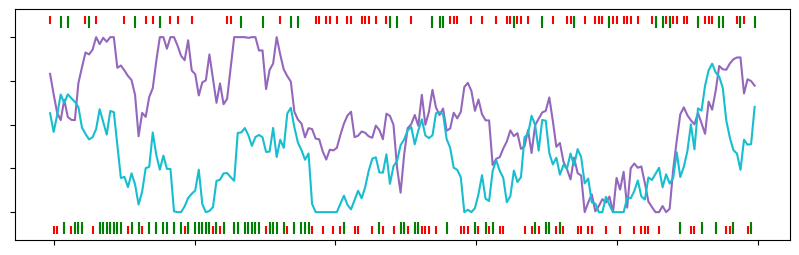

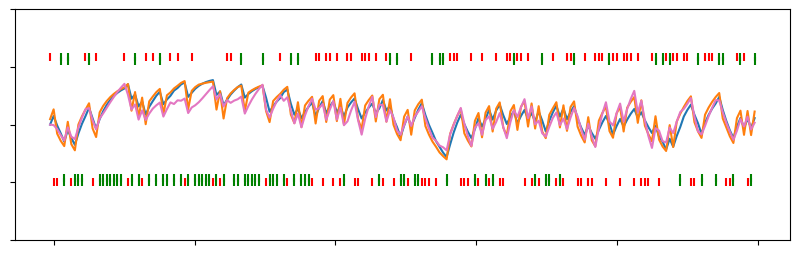

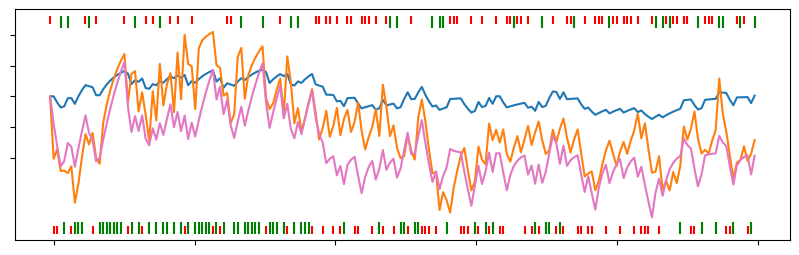

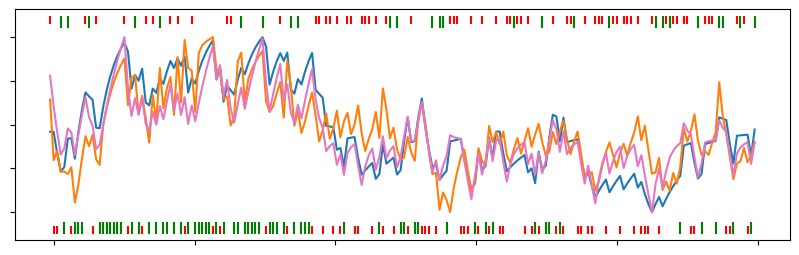

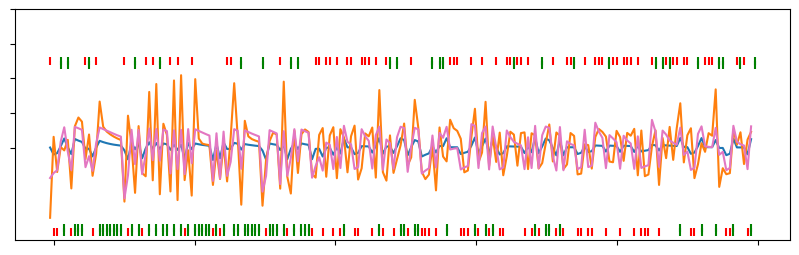

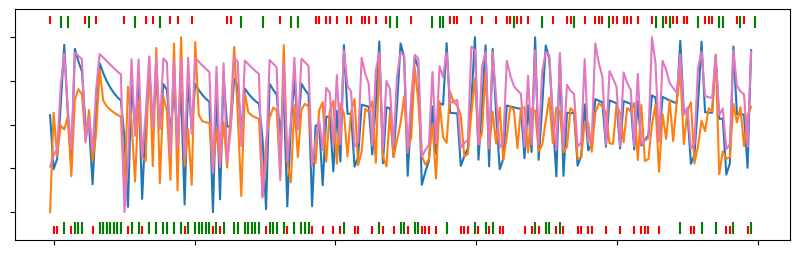

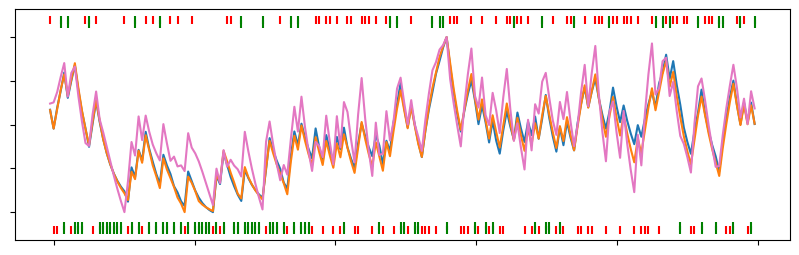

In [12]:
#@title Plot action similarities.

# plot reward probabilities
experiment_list_test = dataset.experiment_list_test
choices = experiment_list_test[session_id].choices
rewards = experiment_list_test[session_id].rewards

reward_probs = np.stack([experiment_list_test[session_id].timeseries[:, i] for i in range(n_actions)], axis=0)
bandits.plot_session(
    compare=True,
    choices=choices, 
    rewards=rewards, 
    timeseries=reward_probs,
    timeseries_name='', # 'Reward Probabilities'
    # labels=[f'Reward Prob {a}' for a in range(n_actions)],
    color=['tab:purple', 'tab:cyan'],
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/reward_probs.png', dpi=1000)

# plot evolution of Q-Values for same reward and choice trial data

list_probs = []
list_qs = []
if label_test in labels:
    qs_test, probs_test = get_q(experiment_list_test[session_id], agent)
    list_probs.append(np.expand_dims(probs_test, 0))
    list_qs.append(np.expand_dims(qs_test, 0))
if label_hybrnn in labels:
    qs_hybrnn, probs_hybrnn = get_q(experiment_list_test[session_id], hybrnn_agent)
    list_probs.append(np.expand_dims(probs_hybrnn, 0))
    list_qs.append(np.expand_dims(qs_hybrnn, 0))
if label_datasindy in labels:
    qs_datasindy, probs_datasindy = get_q(experiment_list_test[session_id], datasindyagent)
    list_probs.append(np.expand_dims(probs_datasindy, 0))
    list_qs.append(np.expand_dims(qs_datasindy, 0))
if label_rnnsindy in labels:
    qs_rnnsindy, probs_rnnsindy = get_q(experiment_list_test[session_id], rnnsindyagent)
    list_probs.append(np.expand_dims(probs_rnnsindy, 0))
    list_qs.append(np.expand_dims(qs_rnnsindy, 0))

# colors = ['cyan', 'magenta', 'yellow', 'grey']
colors = ['tab:blue', 'tab:orange', 'tab:pink', 'tab:gray']

# concatenate all choice probs and q-values
probs = np.concatenate(list_probs, axis=0)
qs = np.concatenate(list_qs, axis=0)

bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=probs[:, :, 0],
    timeseries_name='', # 'Choice Probabilities',
    # labels=labels,
    color=colors,
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/choice_probs.png', dpi=1000)

bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=qs[:, :, 0],
    timeseries_name='', # 'Q-Values',
    # labels=labels,
    color=colors,
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/q_values.png', dpi=1000)

def normalize(x, axis=1):
    x_min = np.min(x, keepdims=True, axis=axis)
    x_max = np.max(x, keepdims=True, axis=axis)
    return (x - x_min) / (x_max - x_min)

qs_norm = normalize(qs)

bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=qs_norm[:, :, 0],
    timeseries_name='', # 'norm. Q-Values',
    # labels=labels,
    color=colors,
    binary=binary,
    )
plt.show() if not save_fig else plt.savefig('plots/q_values_norm.png', dpi=1000)

dqs_trials = np.diff(qs, axis=1)
# for i in range(1, len(qs)):
bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=dqs_trials[:, :, 0],
    timeseries_name='', # 'dQ/dt',
    # labels=labels,
    color=colors,
    binary=binary,
)
# plt.legend()
plt.show() if not save_fig else plt.savefig('plots/dq_dt.png', dpi=1000)

norm_dqs_trials = normalize(dqs_trials)
bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=norm_dqs_trials[:, :, 0],
    timeseries_name='', # 'norm. dQ/dt',
    # labels=labels,
    color=colors,
    binary=binary,
)
# plt.legend()
plt.show() if not save_fig else plt.savefig('plots/dq_dt.png', dpi=1000)

dqs_arms = np.diff(qs, axis=2)
norm_dqs_arms = normalize(dqs_arms)
# dqs_arms /= np.max(np.abs(dqs_arms), axis=(1, 2), keepdims=True)
bandits.plot_session(
    compare=True,
    choices=choices,
    rewards=rewards,
    timeseries=norm_dqs_arms,
    timeseries_name='', # 'dQ/dArm',
    # # labels=labels,
    color=colors,
    binary=binary,
)
plt.show() if not save_fig else plt.savefig('plots/dq_darm.png', dpi=1000)

# Calculate reward rates
# Plot proportion Leftward Choices over difference in reward prob (left vs right)

# experiment_list = []
# if label_test in labels:
#     print('Test dataset:')
#     bandits.show_total_reward_rate(experiment_list_test)
#     bandits.show_valuemetric(experiment_list_test, label=label_test)
#     experiment_list.append(experiment_list_test)
# if label_hybrnn in labels:
#     print('RNN dataset:')
#     bandits.show_total_reward_rate(experiment_list_hybrnn)
#     bandits.show_valuemetric(experiment_list_hybrnn, label=label_hybrnn)
#     experiment_list.append(experiment_list_hybrnn)
# if label_datasindy in labels:
#     print('Data SINDy dataset:')
#     bandits.show_total_reward_rate(experiment_list_datasindy)
#     bandits.show_valuemetric(experiment_list_datasindy, label=label_datasindy)
#     experiment_list.append(experiment_list_datasindy)
# if label_rnnsindy in labels:
#     print('RNN SINDy dataset:')
#     bandits.show_total_reward_rate(experiment_list_rnnsindy)
#     bandits.show_valuemetric(experiment_list_rnnsindy, label=label_rnnsindy)
#     experiment_list.append(experiment_list_rnnsindy)
# plt.legend()
# plt.show()

# # plot choice similarity over history
# plt.figure()
# plot_action_similarity_to_history(experiment_list, n_steps_back=16, labels=labels, bbox_to_anchor=(1, 1))
# plt.show()

In [11]:
# check for correctly recovered parameters
# groundtruth equation: Q_k+1 = f Q_init + (1-f) Q_k - f * alpha * Q_init * c - (1-f) * alpha * c * Q_k + alpha * c * r
# equations = ['1','q','c','r','q^2','q c','q r','c^2','c r','r^2','q^3','q^2 c','q^2 r','q c^2','q c r','q r^2','c^3','c^2 r','c r^2','r^3']
# similar = [0, 1, 2, 3, 4, 5, 6, 2, 7, 3, 8, 9, 10, 5, ]
# groundtruth coefficients for model w/ and w/o forgetting; for polynomial order 3 library
groundtruth_coeffs = [forgetting_rate * 0.5, 1-forgetting_rate, -0.5*gen_alpha*forgetting_rate, 0, 0, -(1-forgetting_rate)*gen_alpha, 0, 0, gen_alpha, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print('Groundtruth coefficients:')
print(groundtruth_coeffs)
sindy_coeffs = rnnsindy.coefficients().reshape(-1).copy()
print('raw SINDy coefficients:')
print(np.round(sindy_coeffs, 2))
# post-processing of sindy coefficients
# sum up all coefficients that encode the same term if their values are equal
equal_terms = {'c': ['c', 'c^2', 'c^3'], 'r': ['r', 'r^2', 'r^3'], 'c r': ['c r', 'c^2 r', 'c r^2'], 'q c': ['q c', 'q c^2'], 'q r': ['q r', 'q r^2']}
sindy_terms = rnnsindy.get_feature_names()
if not non_binary_reward:
    for term in equal_terms.keys():
        for equal_term in equal_terms[term]:
            if equal_term in sindy_terms:
                if equal_term != term:
                    sindy_coeffs[sindy_terms.index(term)] += sindy_coeffs[sindy_terms.index(equal_term)]
                    sindy_coeffs[sindy_terms.index(equal_term)] = 0

print('post-processed SINDy coefficients:')
# filter all remaining coeffs which are lower than threshold
sindy_coeffs[np.abs(sindy_coeffs) < threshold] = 0
print(np.round(sindy_coeffs, 2))

# get number of correctly recovered terms
correct_terms = 0
for i in range(len(sindy_terms)):
    if groundtruth_coeffs[i] != 0 and sindy_coeffs[i] != 0:
        correct_terms += 1
    elif groundtruth_coeffs[i] == 0 and sindy_coeffs[i] == 0:
        correct_terms += 1

# substract the equal terms
substracted_terms = 0
if not non_binary_reward:
    for term in equal_terms.keys():
        if term in sindy_terms:
            substracted_terms += 1
print(f'Correctly recovered terms: {correct_terms-substracted_terms}/{len(sindy_terms)-substracted_terms}')

# list_coeffs = [[sindy_terms[i], groundtruth_coeffs[i], np.round(sindy_coeffs[i], 2), np.round(rnnsindy.coefficients().reshape(-1)[i], 2)] for i in range(len(sindy_terms))]
# list_features = ['term', 'groundtruth', 'sindy', 'sindy_orig']

list_coeffs = [[sindy_terms[i], groundtruth_coeffs[i], np.round(sindy_coeffs[i], 2)] for i in range(len(sindy_terms))]
list_features = ['term', 'groundtruth', 'sindy']

print(list_features)
for i in range(len(list_coeffs)):
    print(list_coeffs[i])
    
import pandas as pd

pd.DataFrame(list_coeffs, columns=list_features).to_csv('recovered_coeffs_beta'+str(gen_beta)+'.csv', index=False)

Groundtruth coefficients:
[0.05, 0.9, -0.0125, 0, 0, -0.225, 0, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
raw SINDy coefficients:
[ 0.00000000e+00  5.90000000e-01  6.93479371e+11  0.00000000e+00
 -5.00000000e-02  7.38462412e+11  2.60888831e+09 -3.42808947e+11
  3.14614397e+11  0.00000000e+00  2.00000000e-02  0.00000000e+00
  3.00000000e-02 -7.38462412e+11 -7.00000000e-02 -2.60888831e+09
 -3.50670424e+11 -1.57307199e+11 -1.57307199e+11  0.00000000e+00]
post-processed SINDy coefficients:
[ 0.    0.59 -0.15  0.   -0.05  0.35  0.05  0.    0.29  0.    0.02  0.
  0.03  0.   -0.07  0.    0.    0.    0.    0.  ]
Correctly recovered terms: 9/15
['term', 'groundtruth', 'sindy']
['1', 0.05, 0.0]
['q', 0.9, 0.59]
['c', -0.0125, -0.15]
['r', 0, 0.0]
['q^2', 0, -0.05]
['q c', -0.225, 0.35]
['q r', 0, 0.05]
['c^2', 0, 0.0]
['c r', 0.25, 0.29]
['r^2', 0, 0.0]
['q^3', 0, 0.02]
['q^2 c', 0, 0.0]
['q^2 r', 0, 0.03]
['q c^2', 0, 0.0]
['q c r', 0, -0.07]
['q r^2', 0, 0.0]
['c^3', 0, 0.0]
['c^2 r', 0, 0.0]


IndexError: list index out of range

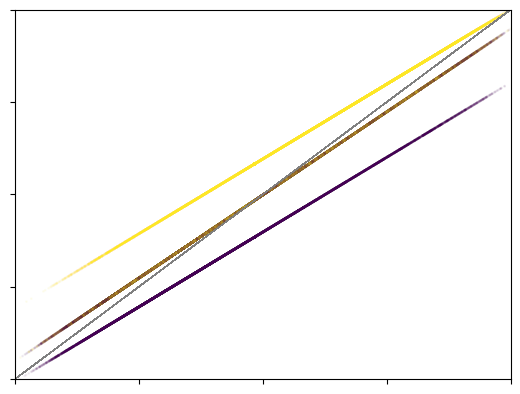

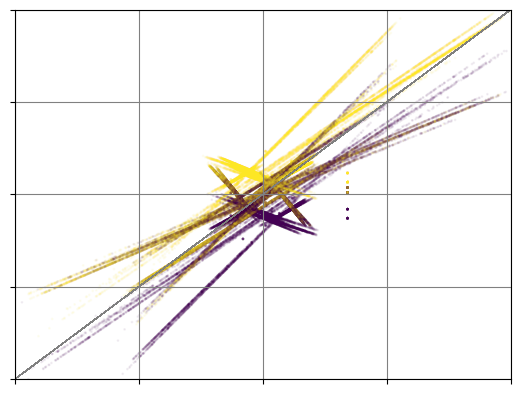

In [12]:
def normalize(x, axis=1):
    x_min = np.min(x) #np.min(x, keepdims=True, axis=axis)
    x_max = np.max(x) #np.max(x, keepdims=True, axis=axis)
    return (x - x_min) / (x_max - x_min)

# take qs_norm as q-values
experiment_dict = {
    label_test: experiment_list_test,
    label_hybrnn: experiment_list_hybrnn, 
    # label_datasindy: experiment_list_datasindy, 
    label_rnnsindy: experiment_list_rnnsindy,
    }

# plot q-value update with old vs new q-values and reward as color
for l in experiment_dict.keys():
    qs = np.stack([experiment_dict[l][session].q for session in range(n_sessions)], axis=1)
    choices = np.stack([experiment_dict[l][session].choices for session in range(n_sessions)], axis=1)
    rewards = np.stack([experiment_dict[l][session].rewards for session in range(n_sessions)], axis=1)
    
    qs = normalize(qs, axis=0)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for session in range(n_sessions):
        ax.plot(np.linspace(-10, 10), np.linspace(-10, 10), 'grey', linewidth=0.5) 
        for arm in range(n_actions):
            q_old = qs[:-1, session, arm]
            q_new = qs[1:, session, arm]
            ax.scatter(q_old, q_new, c=experiment_dict[l][session].rewards[:-1], alpha=.05, s=1)
    # set colorbar
    # cbar = plt.colorbar(ax.scatter([], [], c=[], alpha=1, s=1))
    # cbar.set_label('Reward')
    q_min = np.min(qs)
    q_max = np.max(qs)
    ax.set_ylim(q_min, q_max)
    ax.set_xlim(q_min, q_max)
    ax.set_xticks(np.linspace(q_min, q_max, 5))
    ax.set_yticks(np.linspace(q_min, q_max, 5))
    ax.set_xticklabels(['']*5)
    ax.set_yticklabels(['']*5)
    plt.rc('grid', color='grey')
    plt.grid()
    # plt.title(l)
    # plt.xlabel('Old Q-Values')
    # plt.ylabel('New Q-Values')
    plt.show() if not save_fig else plt.savefig(f'plots/q_value_update_{l}.png', dpi=1000)